# ***A decision support system to recommend appropriate therapy protocol for AML patients***
---
# **Experiments**

In this notebook,you will find the Python script associated with the experiments conducted in the paper "*A decision support system to recommend appropriate therapy protocol for AML patients*", serving as a comprehensive repository of all experiments conducted to attain the results outlined in t3he article.

This code encapsulates the methodological details and computational procedures employed to generate the findings presented in the paper, from the data processing stage to the final models generated.

Researchers and practitioners interested in replicating or further extending these experiments will find this script to be a valuable resource, providing both transparency and reproducibility for the scientific community.



## **Loading the data...**

Here we load the dataframes from the project's github repository.
The data used in this study is provenient from The Cancer Genome Atlas Program and from a study conducted by the Oregon University. At this moment, these datasets are already cleaned and preprocessed, with spurious data cleaned, empty values filled and unifying samples from both studies.

To better understand the preprocessing steps used before this stage, please refer to the article.


In [5]:
import pandas as pd

#path to the repository
PATH = "https://raw.githubusercontent.com/jdmanzur/ml4aml/main/ensemble_experiments_databases/"

#loading the dataframes
df_clinical_global = pd.read_csv(PATH + 'clinical_data/clinicaldata_merged_final.csv', sep=',', index_col=None) #clinical data
df_clinical_global = df_clinical_global.drop(columns=['Overall Survival (Months)']) #we are removing this column because it is not available at the time of diagnosis
df_expressions_global = pd.read_csv(PATH + 'genetic_data/expressions/expressions_merged_final.csv', sep=',', index_col=None) #gene mutation data
df_mutation_global = pd.read_csv(PATH + 'genetic_data/mutations/mutations_merged_final.csv', index_col=None) #gene expression data

## **Pre-processing methods**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

#path to the repository folder with the train, validation and test splits.
PATH_PREPROCESS = "https://raw.githubusercontent.com/jdmanzur/ml4aml_databases/main/train_test_split/"
KEY_MERGE = 'SAMPLE_ID'  #variable to be used to merge and split dataframes
CLASS_VARIABLE = "Overall Survival Status" #target variable
TREATMENT =  'Treatment Intensity' #treatment intensity variable


"""
    Merges two dataframes based on a key. The key must be present in both datasets.
    - params dataset1 and dataset2: datasets to be merged together
    - param key: key variable to merge both dataframes on.

    - returns a new dataframe, resulting from the merge of dataset1 and dataset2
"""
def mergeDataSetsByKey(dataset1, dataset2, key):
    newDataSet = pd.merge(dataset1, dataset2, on=key)
    return newDataSet


"""
    With a Label Enconder, converts the target variable to a numeric label.
    - params df_dataset: dataframe with the target variable
    - param class_label: name of the target variable to be encoded

    - returns a new dataframe with the labels encoded.
"""
def convertClassToNumber(df_dataset, class_label):
    label_encoder = LabelEncoder()
    df_dataset[class_label] = label_encoder.fit_transform(df_dataset[class_label])

    return df_dataset


"""
    Method to apply zscore normalization on the numeric columns of a clinical dataset
    - params df_dataset: clinical data dataframe

    - returns a new dataframe with the variables in the default list normalized.
"""
def normalizeData(df_dataset):
    #list of numeric features to be normalized
    column_list = ["Diagnosis Age", "Bone Marrow Blast Percentage", "Mutation Count", "PB Blast Percentage", "WBC"]

    for column in column_list:
        df_dataset[column] = zscore(df_dataset[column]) #applies zscore normalization for each column
    return df_dataset


"""
    Applies a simple preprocessing step by droping unnecessary features and converting categorical features to dummies.
    - param df_dataset: dataframe
    - param to_drop: list of features to be dropped, by default, drops ID columns

    - returns a new dataframe without the features in the to_drop list and with categorical variables encoded.
"""
def preprocessingDataModel(df_dataset, to_drop=['Study ID', KEY_MERGE]):
    df_dataset = df_dataset.drop(columns=to_drop)
    return pd.get_dummies(df_dataset)



"""
    Adds treatment intensity information to genetic datasets
    - param df_clinical: clinical dataframe
    - param data: gene mutation or gene expression dataframe

    - returns a new dataframe that merges data with the treatment intensity feature from the clinical dataframe.
"""
def putTreatmentDataIntoGenetic(df_clinical, data):

    df_treatment = df_clinical[TREATMENT]
    df_treatment = pd.get_dummies(df_treatment)
    df_treatment.insert(0, KEY_MERGE, df_clinical[KEY_MERGE])

    return mergeDataSetsByKey(df_treatment, data, KEY_MERGE)



"""
   Generic method to preprocess the data and split into train, validation and test sets
    - param data_clin: clinical dataframe
    - param data_mut (optional): gene mutation dataframe
    - param data_exp (optional): gene expressio dataframe
    - param to_merge: list with labels, indicating with dataframes to merge together

    - returns train, validation and test splits for the input dataframes.
"""
def preprocess(data_clin, data_mut=None, data_exp=None, to_merge="CLIN"):

  #converts target variable to a numeric label
  data_clin = convertClassToNumber(data_clin, CLASS_VARIABLE)

  id_table = data_clin[KEY_MERGE] #isolates the IDs of the samples

  #isolating the IDs and the class into a separate dataframe
  data = data_clin[[KEY_MERGE, CLASS_VARIABLE]]

  #if the preprocessing method receiving a "CLIN" in to_merge, adds clinical data to the final dataset
  if "CLIN" in to_merge:
    #calls preprocessing method to drop columns and preprocess categorical features
    data = preprocessingDataModel(data_clin)

    #normalize continuous data to same distribution
    data = normalizeData(data)
    data.insert(0, KEY_MERGE, id_table) #inserts IDs

  #if the preprocessing method receiving a "MUT" in to_merge, adds gene mutation data to the final dataset
  if "MUT" in to_merge:
    data = mergeDataSetsByKey(data_mut, data, KEY_MERGE) #merges the gene mutation dataframe with the target variable and IDs

  #if the preprocessing method receiving a "EXP" in to_merge, adds gene expression data to the final dataset
  if "EXP" in to_merge:
    data = mergeDataSetsByKey(data_exp, data, KEY_MERGE) #merges the gene expression dataframe with the target variable and IDs

  #we use the process above to be able to generate dataframes with the combination of the three datasets, so with the same code
  #we can not only preprocess and get ready the clinical, gene mutation or gene expression datasets but it is possible to combine the datasets into one as well


  #now we load the train, validation, test and final test splits
  X_train_id = pd.read_csv(PATH_PREPROCESS+'X_train_id.csv', sep=',', index_col=None)
  X_valid_id = pd.read_csv(PATH_PREPROCESS+'X_valid_id.csv', sep=',', index_col=None)
  X_test_id = pd.read_csv(PATH_PREPROCESS+'X_test_id.csv', sep=',', index_col=None)
  X_final_test_id = pd.read_csv(PATH_PREPROCESS+'X_final_test_id.csv', sep=',', index_col=None)

  #concatenates all the splits to generate a full list of all samples
  #we do that because there are samples in genetic datasets that are not in the clinical dataset
  #creating a full list of samples allows us to use the same samples for all datasets
  X_id = pd.concat([X_train_id, X_valid_id, X_test_id, X_final_test_id])

  #uses the full list of IDs to generate a dataset with all samples
  X = mergeDataSetsByKey(X_id, data, KEY_MERGE)
  y = X[CLASS_VARIABLE]
  X = X.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  #splitting the training dataset
  X_train = mergeDataSetsByKey(X_train_id, data, KEY_MERGE)
  y_train = X_train[CLASS_VARIABLE]
  X_train = X_train.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  #splitting the validation dataset
  X_valid = mergeDataSetsByKey(X_valid_id, data, KEY_MERGE)
  y_valid = X_valid[CLASS_VARIABLE]
  X_valid = X_valid.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  #splitting the test dataset
  X_test = mergeDataSetsByKey(X_test_id, data, KEY_MERGE)
  y_test = X_test[CLASS_VARIABLE]
  X_test = X_test.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  #splitting the final test dataset - TO BE USED ONLY BT THE FINAL ENSEMBLE.
  X_final_test = mergeDataSetsByKey(X_final_test_id, data, KEY_MERGE)
  y_final_test = X_final_test[CLASS_VARIABLE]
  X_final_test = X_final_test.drop(columns=[CLASS_VARIABLE, KEY_MERGE])

  #returns the training set, validation set, test set, final test set and the full datasets in [X,y]
  return X_train, y_train, X_valid, y_valid, X_test, y_test, X_final_test, y_final_test, [X,y]


## **Feature Selection**

---



In this stage we perform feature selection for gene mutation and gene expression data. The clinical features were already selected beforehand by specialists.

### Gene Mutation Feature Selection

For the gene mutation features, we employ the Chi-Square method to select the most relevant features.

In [ ]:
#calls the preprocessing method to preprocess the gene mutation dataset and split it into the necessary sets for feature selection
mut_train, mut_y_train, mut_valid, mut_y_valid, mut_test, mut_y_test, mut_final_test, mut_y_final_test, [mut_X,mut_y] = preprocess(df_clinical_global, data_mut=df_mutation_global, to_merge="MUT")

In [ ]:
from sklearn.feature_selection import chi2

#joins the training and validation set for feature selection
data_mut_select = pd.concat([mut_train, mut_valid])
data_mut_select_y = pd.concat([mut_y_train, mut_y_valid])

#gets the chi-squares scores for the gene mutation set
chi_scores = chi2(data_mut_select, data_mut_select_y)
#sorts the scores by value, in descending order
p_values = pd.Series(chi_scores[1],index = data_mut_select.columns)
p_values.sort_values(ascending = False , inplace = True)

#with an alpha value of 0.1, selects all features where the score is < than alpha.
alpha = 0.1
selected_mut_features = p_values.loc[lambda x: x < alpha]
selected_mut_features = list(selected_mut_features.index)

#sorts the feature names alphabetically
selected_mut_features.sort()
print(selected_mut_features)

# ['U2AF1', 'CADM2', 'CALR', 'CTNNA2', 'PRKAA2', 'RIF1', 'SRSF2', 'PTPN11', 'PHF6', 'TP53']

['CADM2', 'CALR', 'CTNNA2', 'PHF6', 'PRKAA2', 'PTPN11', 'RIF1', 'SRSF2', 'TP53', 'U2AF1']


### Gene Expression Feature Selecion

For the gene expression dataset, we employed the LASSO method, using an SVM with L1 regularization.

In [ ]:
#calls the preprocessing method to preprocess the gene expression dataset and split it into the necessary sets for feature selection
exp_train, exp_y_train, exp_valid, exp_y_valid, exp_test, exp_y_test, exp_final_test, exp_y_final_test, [exp_X,exp_y] = preprocess(df_clinical_global, data_exp=df_expressions_global, to_merge="EXP")

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

#joins the training and validation sets for feature selection
data_exp_select = pd.concat([exp_train, exp_valid])
data_exp_select_y = pd.concat([exp_y_train, exp_y_valid])

#creates an empty list to put the features in
selected_exp_features = []

#trains a SVM model with L1 regularization
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, random_state=0)
lsvc.fit(data_exp_select, data_exp_select_y)

#uses the SelectFromModel method to extract the features that have an weight associated with them
selector = SelectFromModel(lsvc, prefit=True)

#extracts the columns from the full dataset
features_exp = df_expressions_global.columns
features_exp = features_exp.to_list()
features_exp.pop(0) #removendo SAMPLE ID

#isolates the selected features
selected_exp_features = [feature for feature, selected in zip(features_exp, selector.get_support()) if selected]

#sorts features alphabetically
selected_exp_features.sort()
print(selected_exp_features)

# ['CCDC144A', 'CPNE8', 'CYP2E1', 'CYTL1', 'HAS1', 'KIAA0141', 'KIAA1549', 'LAMA2', 'LTK', 'MICALL2', 'MX1', 'PPM1H', 'PTH2R', 'PTP4A3', 'RAD21', 'RGS9BP', 'SLC29A2', 'TMED4', 'TNFSF11', 'TNK1', 'TSKS', 'XIST']

['CCDC144A', 'CPNE8', 'CYP2E1', 'CYTL1', 'HAS1', 'KIAA0141', 'KIAA1549', 'LAMA2', 'LTK', 'MICALL2', 'MX1', 'PPM1H', 'PTH2R', 'PTP4A3', 'RAD21', 'RGS9BP', 'SLC29A2', 'TMED4', 'TNFSF11', 'TNK1', 'TSKS', 'XIST']


## **Individual Model Training**


---



### Auxiliar Methods

In [ ]:
import seaborn as sns
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer



"""
    Generates a confusion matrix plot given two prediction arrays
    - params y_test and y_pred: arrays with prediction labels to generate the confusion matrix

    - shows a confusion matrix plot
"""
def conf_matrix(y_test, y_pred):

    total_cm = metrics.confusion_matrix(y_test, y_pred)

    group_counts = ["{0:0.0f}".format(value) for value in total_cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in total_cm.flatten()/np.sum(total_cm)]
    labels = [f"{v1}\n{v2}" for v1,v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(total_cm, annot=labels, fmt="", annot_kws={"size":20})

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()



"""
    Displays a performance report given two prediction arrays
    - params y_test and y_pred: arrays with prediction labels to generate the report
    (y_test represents the true labels and y_pred the predicted ones)

    - shows a performance report with F1, AUC, Accuracy, Precision, Recall, Matthews Coefficient.
"""
def checkPerformance(y_test, y_pred, verbose=True):

    f1_result = metrics.f1_score(y_test, y_pred, average="weighted", zero_division=1)
    pres = metrics.precision_score(y_test, y_pred, average="weighted", zero_division=1)
    recall = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=1)
    acc = metrics.accuracy_score(y_test, y_pred)
    mat_coef = matthews_corrcoef(y_test, y_pred)

    try:
        roc = metrics.roc_auc_score(y_test, y_pred)
    except ValueError:
        roc = 0

    if (verbose == True):
      print("F1: %.4f%%" % (f1_result))
      print("AUC: %.4f%%" % (roc))
      print("Accuracy: %.4f%%" % (acc))
      print("Precision: %.4f%%" % (pres))
      print("Recall: %.4f%%" % (recall))
      print("Matthews Coef: %.4f%%" % (mat_coef))


    return f1_result, pres, recall, acc, roc, mat_coef



"""
    Trains a random forest model with grid search
    - params X_train, y_train, X_valid, y_valid, X_test and y_test: training, validation and test sets
    - param name: string that represents the name of the model, to be stored in the results dictionary

    - returns the true labels, the predicted test labels, a dictionary with results and the model instance
"""
def randomForestModel(X_train, y_train, X_valid, y_valid, X_test, y_test, name):

    #creates a parameter grid for the model
    grid = {
        'random_state' : [1],
        "n_estimators":[10, 15, 20, 25, 30, 45, 50],
        'min_samples_leaf':[1,2,3,4],
        'max_depth':[8, 10, None],
        'class_weight':['balanced', None]
    }

    #creating a grid search with 5-fold cross-validation
    cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv=5)
    cv.fit(X_train, y_train) #fitting the training set


    #joining validation and training sets
    X_train = pd.concat([X_train, X_valid])
    y_train = pd.concat([y_train, y_valid])

    #the best parameters from the previous
    rf = RandomForestClassifier(**cv.best_params_)#, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)

    #test predictions
    y_pred = rf.predict(X_test)

    #performance report
    print("\nTest Performance")
    f1_result, pres, recall, acc, roc, mat_coef = checkPerformance(y_test, y_pred)

    #saving report in dictionary
    results = {"model":name, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc,
    "Precision":pres,
    "Recall":recall,
    "Matthews": mat_coef,
    }
    results = pd.DataFrame(data=[results])

    #plots confusion matrix
    conf_matrix(y_test, y_pred)

    return y_pred, results, rf




"""
    Trains a SVM model with grid search
    - params X_train, y_train, X_valid, y_valid, X_test and y_test: training, validation and test sets
    - param name: string that represents the name of the model, to be stored in the results dictionary

    - returns the true labels, the predicted test labels, a dictionary with results and the model instance
"""
def svmModel(X_train, y_train, X_valid, y_valid, X_test, y_test, name):

    #creates a parameter grid for the model
    C_space = np.logspace(start=-6, stop=-2, num=5)

    grid = {
        'class_weight': ['balanced', None],
        'kernel':['linear', 'rbf'],
        'C':C_space,
        'probability': [True]
    }

    #creating a grid search with 5-fold cross-validation
    cv = GridSearchCV(estimator=svm.SVC(), param_grid=grid, cv=5)
    cv.fit(X_train, y_train)  #fitting the training set

    #joining training and validation sets
    X_train = pd.concat([X_train, X_valid])
    y_train = pd.concat([y_train, y_valid])

    #create a SVM Classifier with the best parameters from the gridsearch training
    clf = svm.SVC(**cv.best_params_)
    clf.fit(X_train, y_train)

    #test predictions
    y_pred = clf.predict(X_test)

    #performance report
    print("\nTest Performance")
    f1_result, pres, recall, acc, roc, mat_coef = checkPerformance(y_test, y_pred)

    #saving test results in dictionary
    results = {"model":name, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc,
    "Precision":pres,
    "Recall":recall,
    "Matthews": mat_coef,
    }
    results = pd.DataFrame(data=[results])

    #plots confusion matrix
    conf_matrix(y_test, y_pred)

    return y_pred, results, clf



"""
    Trains a logistic regression model with grid search
    - params X_train, y_train, X_valid, y_valid, X_test and y_test: training, validation and test sets
    - param name: string that represents the name of the model, to be stored in the results dictionary

    - returns the true labels, the predicted test labels, a dictionary with results and the model instance
"""
def logisticRegressionModel(X_train, y_train, X_valid, y_valid, X_test, y_test, name):

    #creates a parameter grid for the model
    C_space = np.logspace(start=-6, stop=1, num=5)

    grid = {
        'class_weight': ['balanced', None],
        'C':C_space,
        'penalty':["l2"],
        'random_state' : [1]
    }

    #creating a grid search with 5-fold cross-validation
    cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, cv=5)
    cv.fit(X_train, y_train)

    #joining training and validation set
    X_train = pd.concat([X_train, X_valid])
    y_train = pd.concat([y_train, y_valid])

    #create a LR Classifier with the best parameters from the gridsearch training
    clf = LogisticRegression(**cv.best_params_)
    clf.fit(X_train, y_train)

    #test predictions
    y_pred = clf.predict(X_test)

    #generating performance report
    print("\nTest Performance")
    f1_result, pres, recall, acc, roc, mat_coef = checkPerformance(y_test, y_pred)

    #saving test results in dictionary
    results = {"model":name, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc,
    "Precision":pres,
    "Recall":recall,
    "Matthews": mat_coef,
    }

    results = pd.DataFrame(data=[results])

    #plots confusion matrix
    conf_matrix(y_test, y_pred)

    return y_pred, results, clf



"""
    Receives three models and three results dictionaries, comparing them with each other and returning the best model and results
    accordingly to a chosen metric
    - params model_rf, rf_results: random forest model and test results dictionary
    - params model_lr, lr_results: logistic regression model and test results dictionary
    - params model_rf, rf_results: svm model and test results dictionary
    - param metric: metric to evaluate and compare each model

    This method first prioritizes the random forest model, due to its better explainability.

    - returns the best model and its results
"""
def findBestModel(model_rf,rf_results, model_lr,lr_results, model_svm, svm_results, metric):

    if( (rf_results[metric] >= lr_results[metric]).any() and (rf_results[metric] >= svm_results[metric]).any() ):
        return model_rf, rf_results
    elif( (lr_results[metric] > rf_results[metric]).any() and (lr_results[metric] > svm_results[metric]).any() ):
        return model_lr, lr_results
    else:
        return model_svm, svm_results

### Clinical Data Model


Clinical Data


Random Forest

Test Performance
F1: 0.6563%
AUC: 0.6222%
Accuracy: 0.6667%
Precision: 0.6555%
Recall: 0.6667%
Matthews Coef: 0.2604%


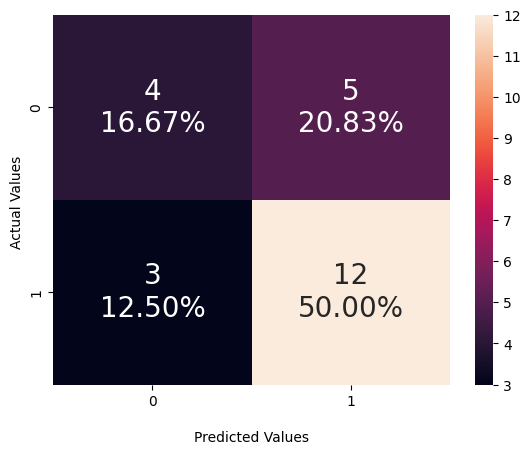

RandomForestClassifier(n_estimators=20, random_state=1)


SVM

Test Performance
F1: 0.6713%
AUC: 0.6889%
Accuracy: 0.6667%
Precision: 0.7133%
Recall: 0.6667%
Matthews Coef: 0.3671%


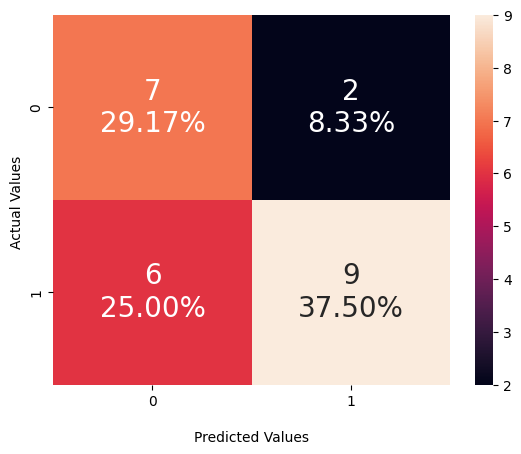

SVC(C=0.01, class_weight='balanced', kernel='linear', probability=True)


Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Test Performance
F1: 0.7045%
AUC: 0.6778%
Accuracy: 0.7083%
Precision: 0.7031%
Recall: 0.7083%
Matthews Coef: 0.3651%


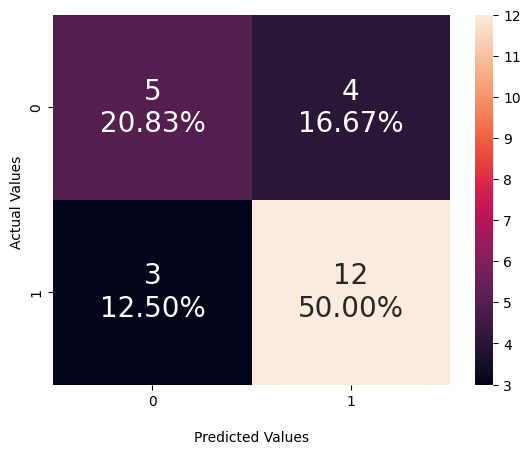

LogisticRegression(C=0.1778279410038923, random_state=1)


In [ ]:
# clinical data model

#creating dataframes to store the results for each model
randomforest_df = pd.DataFrame()
logisticreg_df = pd.DataFrame()
svm_df = pd.DataFrame()

#preprocessing clinical data
clin_train, clin_y_train, clin_valid, clin_y_valid, clin_test, clin_y_test, clin_final_test, clin_y_final_test, [clin_X,clin_y] = preprocess(df_clinical_global, to_merge="CLIN")

print("\nClinical Data")

#random forest model for clinical data
print("\n\nRandom Forest")
pred, results_rf, clin_rf = randomForestModel(clin_train, clin_y_train, clin_valid, clin_y_valid, clin_test, clin_y_test, "CLIN")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(clin_rf)

#svm model for clinical data
print("\n\nSVM")
pred, results_svm, clin_svm = svmModel(clin_train, clin_y_train, clin_valid, clin_y_valid, clin_test, clin_y_test, "CLIN")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(clin_svm)

#logistic regres model for clinical data
print("\n\nLogistic Regression")
pred, results_lr, clin_lr = logisticRegressionModel(clin_train, clin_y_train, clin_valid, clin_y_valid, clin_test, clin_y_test, "CLIN")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(clin_lr)

#selects best model
best_clin, best_clin_results = findBestModel(clin_rf, results_rf,clin_lr, results_lr,clin_svm, results_svm, 'F1-Score')


### Gene Mutation Model


Mutation Data


Random Forest

Test Performance
F1: 0.7130%
AUC: 0.7222%
Accuracy: 0.7083%
Precision: 0.7396%
Recall: 0.7083%
Matthews Coef: 0.4303%


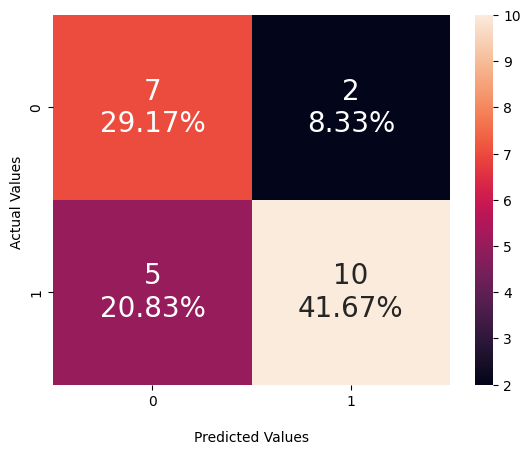

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=2,
                       n_estimators=30, random_state=1)


SVM

Test Performance
F1: 0.4808%
AUC: 0.5000%
Accuracy: 0.6250%
Precision: 0.7656%
Recall: 0.6250%
Matthews Coef: 0.0000%


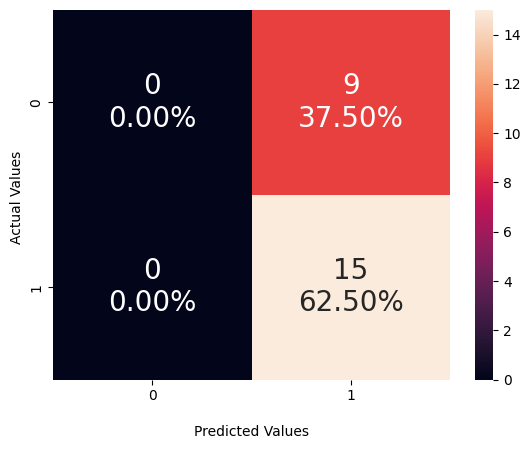

SVC(C=0.0001, class_weight='balanced', kernel='linear', probability=True)


Logistic Regression

Test Performance
F1: 0.7130%
AUC: 0.7222%
Accuracy: 0.7083%
Precision: 0.7396%
Recall: 0.7083%
Matthews Coef: 0.4303%


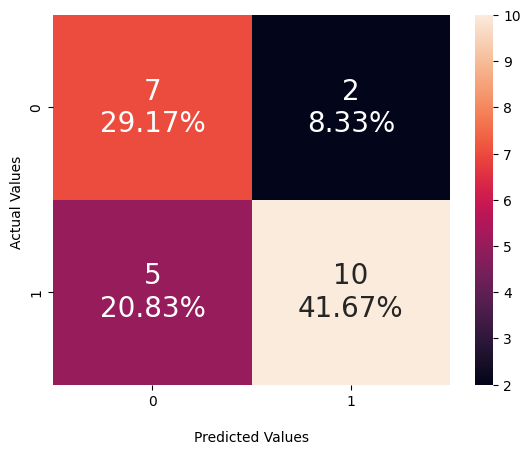

LogisticRegression(C=10.0, class_weight='balanced', random_state=1)


In [ ]:
# gene mutation data model

print("\nMutation Data")

#preprocessing data for the gene mutation dataset, adding treatment info and getting only the selected features
df_mutation_selected_features = df_mutation_global[selected_mut_features]
df_mutation_selected_features.insert(0, KEY_MERGE, df_mutation_global[KEY_MERGE])
df_mutation_selected_features = putTreatmentDataIntoGenetic(df_clinical_global, df_mutation_selected_features)

#splitting data intro training, validation and test
mut_train, mut_y_train, mut_valid, mut_y_valid, mut_test, mut_y_test, mut_final_test, mut_y_final_test, [mut_X,mut_y] = preprocess(df_clinical_global,
data_mut=df_mutation_selected_features, to_merge="MUT")


#random forest model for gene mutation data
print("\n\nRandom Forest")
pred, results_rf, mut_rf = randomForestModel(mut_train, mut_y_train, mut_valid, mut_y_valid, mut_test, mut_y_test, "MUT")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(mut_rf)

#svm model for gene mutation data
print("\n\nSVM")
pred, results_svm, mut_svm = svmModel(mut_train, mut_y_train, mut_valid, mut_y_valid, mut_test, mut_y_test, "MUT")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(mut_svm)

#logistic regression model for gene mutation data
print("\n\nLogistic Regression")
pred, results_lr, mut_lr = logisticRegressionModel(mut_train, mut_y_train, mut_valid, mut_y_valid, mut_test, mut_y_test, "MUT")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(mut_lr)


#selects best model
best_mut, best_mut_results = findBestModel(mut_rf, results_rf,mut_lr, results_lr,mut_svm, results_svm, 'F1-Score')


### Gene Expression Model


Expression Data


Random Forest

Test Performance
F1: 0.7803%
AUC: 0.7444%
Accuracy: 0.7917%
Precision: 0.7986%
Recall: 0.7917%
Matthews Coef: 0.5466%


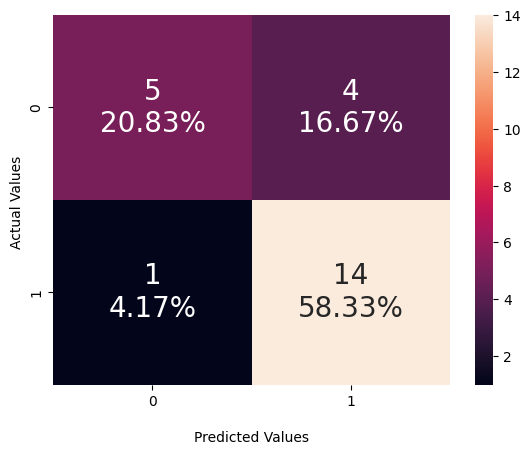

RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=4,
                       n_estimators=10, random_state=1)


SVM

Test Performance
F1: 0.6284%
AUC: 0.6111%
Accuracy: 0.6250%
Precision: 0.6339%
Recall: 0.6250%
Matthews Coef: 0.2182%


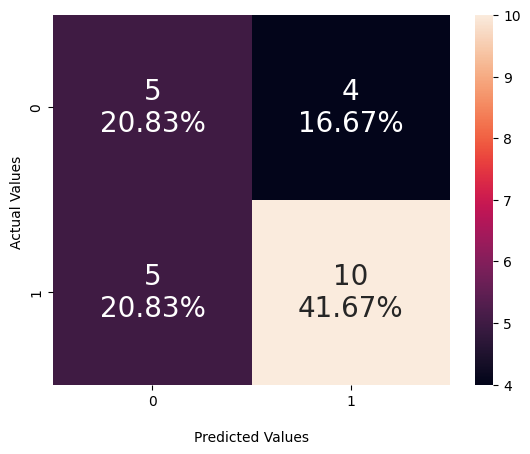

SVC(C=0.01, class_weight='balanced', kernel='linear', probability=True)


Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Test Performance
F1: 0.6200%
AUC: 0.5889%
Accuracy: 0.6250%
Precision: 0.6172%
Recall: 0.6250%
Matthews Coef: 0.1826%


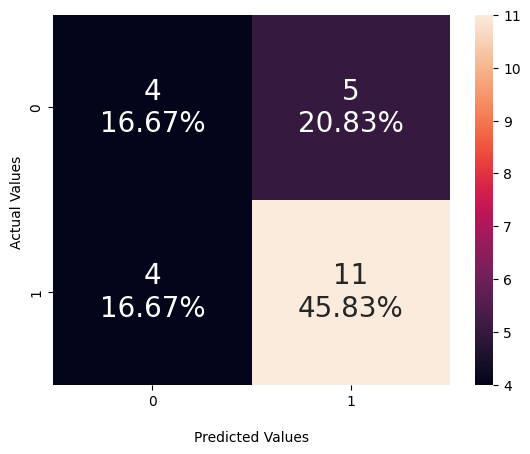

LogisticRegression(C=10.0, random_state=1)


In [ ]:
# gene expression data model


print("\nExpression Data")

#preprocessing data for the gene expression dataset, adding treatment info and getting only the selected features
df_expression_selected_features = df_expressions_global[selected_exp_features]
df_expression_selected_features.insert(0, KEY_MERGE, df_expressions_global[KEY_MERGE])
df_expression_selected_features = putTreatmentDataIntoGenetic(df_clinical_global, df_expression_selected_features)

#splitting data intro training, validation and test
exp_train, exp_y_train, exp_valid, exp_y_valid, exp_test, exp_y_test, exp_final_test, exp_y_final_test, [exp_X,exp_y] = preprocess(df_clinical_global,
data_exp=df_expression_selected_features, to_merge="EXP")


#random forest model for gene expression data
print("\n\nRandom Forest")
pred, results_rf, exp_rf = randomForestModel(exp_train, exp_y_train, exp_valid, exp_y_valid, exp_test, exp_y_test, "EXP")
randomforest_df = pd.concat([randomforest_df, results_rf], ignore_index=True)
print(exp_rf)

#svm model for gene expression data
print("\n\nSVM")
pred, results_svm, exp_svm = svmModel(exp_train, exp_y_train, exp_valid, exp_y_valid, exp_test, exp_y_test, "EXP")
svm_df = pd.concat([svm_df, results_svm], ignore_index=True)
print(exp_svm)


#logistic regression model for gene expression data
print("\n\nLogistic Regression")
pred, results_lr, exp_lr = logisticRegressionModel(exp_train, exp_y_train, exp_valid, exp_y_valid, exp_test, exp_y_test, "EXP")
logisticreg_df = pd.concat([logisticreg_df, results_lr], ignore_index=True)
print(exp_lr)

#selecting best model
best_exp, best_exp_results = findBestModel(exp_rf, results_rf, exp_lr, results_lr, exp_svm, results_svm, 'F1-Score')


### Reporting the results

In [ ]:
#uncomment these lines to save the dataframes with the model's training results
# randomforest_df.to_csv(PATH+"randomforest_results.csv", index=False)
# svm_df.to_csv(PATH+"svm_results.csv", index=False)
# logisticreg_df.to_csv(PATH+"logisticreg_results.csv", index=False)

#displays results as latex table
print(randomforest_df.to_latex())

print(svm_df.to_latex())

print(logisticreg_df.to_latex())


\begin{tabular}{llrrrrrr}
\toprule
{} & model &  F1-Score &       AUC &  Accuracy &  Precision &    Recall &  Matthews \\
\midrule
0 &  CLIN &  0.656250 &  0.622222 &  0.666667 &   0.655462 &  0.666667 &  0.260360 \\
1 &   MUT &  0.712963 &  0.722222 &  0.708333 &   0.739583 &  0.708333 &  0.430331 \\
2 &   EXP &  0.780303 &  0.744444 &  0.791667 &   0.798611 &  0.791667 &  0.546594 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrr}
\toprule
{} & model &  F1-Score &       AUC &  Accuracy &  Precision &    Recall &  Matthews \\
\midrule
0 &  CLIN &  0.671329 &  0.688889 &  0.666667 &   0.713287 &  0.666667 &  0.367058 \\
1 &   MUT &  0.480769 &  0.500000 &  0.625000 &   0.765625 &  0.625000 &  0.000000 \\
2 &   EXP &  0.628403 &  0.611111 &  0.625000 &   0.633929 &  0.625000 &  0.218218 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrr}
\toprule
{} & model &  F1-Score &       AUC &  Accuracy &  Precision &    Recall &  Matthews \\
\midrule
0 &  CLIN &  0.704459 &  0.677778 &  

<ipython-input-12-bdc2b61b2b87>:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(randomforest_df.to_latex())
<ipython-input-12-bdc2b61b2b87>:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_df.to_latex())
<ipython-input-12-bdc2b61b2b87>:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended ins

## **Creating the ensembles**

---



### Auxiliar Methods

In [ ]:
from sklearn.utils.extmath import weighted_mode
from statistics import mode
from math import ceil

"""
    Generates a majority voting ensembles with a holdout protocol
    - param predictions: prediction array with consolidated predictions from all models that compose the ensemble
    - param weights: weights array to ponder the voting of the ensemble
    - param y_test: array with true test labels
    - param title: model name to be used in saving the results in a dictionary
    - param useavg: parameter to define wheter to use pondered voting or mode. Defaults to False, which tells the ensemble to vote by mode of labels.
    - param verbose: boolean value to display or not ensemble results and confusion matrix.

    - shows a performance report with F1, AUC, Accuracy, Precision, Recall, Matthews Coefficient.
"""
def ensembleModelHoldout(preditions, weights, y_test, title, useavg=False, verbose=True):

    #empty prediction list to save ensemble resulting predictions
    ensemble_pred = []

    #if useavg is True, uses a weighted mode approach to select the majority mode.
    if useavg == True:
        for i in range(len(preditions)):
            ensemble_pred.append( mode(np.repeat(preditions[i], weights)) ) #mode weighted
    else:
      #if useavg is False, computes prediction using mode only
        for i in range(len(preditions)):
            ensemble_pred.append(mode(preditions[i])) #normal mode

    #generates perfomance report for the ensemble predictions
    f1_result, pres, recall, acc, roc, mat_coef = checkPerformance(ensemble_pred, y_test)

    #saves results metrics in dictionary
    results = {"model":title, "F1-Score":f1_result, "AUC": roc,
    "Accuracy": acc,
    "Precision":pres,
    "Recall":recall,
    "Matthews": mat_coef
    }

    results = pd.DataFrame(data=[results])

    #displays a confusion matrix
    if(verbose == True):
          conf_matrix(ensemble_pred, y_test)

    return results

### Preparing the data...

In [ ]:
#joins training, validation and test sets to train the models that will compose the ensemble
data_clin_train = pd.concat([clin_train, clin_valid, clin_test])
data_clin_y_train = pd.concat([clin_y_train, clin_y_valid, clin_y_test])

data_mut_train = pd.concat([mut_train, mut_valid, mut_test])
data_mut_y_train = pd.concat([mut_y_train, mut_y_valid, mut_y_test])

data_exp_train = pd.concat([exp_train, exp_valid, exp_test])
data_exp_y_train = pd.concat([exp_y_train, exp_y_valid, exp_y_test])

### Training the best individual models

In [ ]:
#retraining the best models with training, validation and test sets and generating the predictions on the final test set
print('\nCLIN')
best_clin.fit(data_clin_train, data_clin_y_train)
clin_pred = best_clin.predict(clin_final_test)
checkPerformance(clin_pred, clin_y_final_test)
print(best_clin)

print('\nMUT')
best_mut.fit(data_mut_train, data_mut_y_train)
mut_pred = best_mut.predict(mut_final_test)
checkPerformance(mut_pred, mut_y_final_test)
print(best_mut)


print('\nEXP')
best_exp.fit(data_exp_train, data_exp_y_train)
exp_pred = best_exp.predict(exp_final_test)
checkPerformance(exp_pred, exp_y_final_test)
print(best_exp)



CLIN
F1: 0.6946%
AUC: 0.6429%
Accuracy: 0.6786%
Precision: 0.7250%
Recall: 0.6786%
Matthews Coef: 0.2582%
LogisticRegression(C=0.1778279410038923, random_state=1)

MUT
F1: 0.6429%
AUC: 0.7000%
Accuracy: 0.6429%
Precision: 0.7571%
Recall: 0.6429%
Matthews Coef: 0.4000%
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=2,
                       n_estimators=30, random_state=1)

EXP
F1: 0.8179%
AUC: 0.8128%
Accuracy: 0.8214%
Precision: 0.8345%
Recall: 0.8214%
Matthews Coef: 0.6512%
RandomForestClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=4,
                       n_estimators=10, random_state=1)


### **Building multiple ensembles**

In [ ]:
from itertools import combinations
#creates a dataframe to save ensemble results
simple_comb = pd.DataFrame()

#the code below generates one ensemble for each possible combination of the three datasets: CLIN, MUT AND EXP
generated_preditions = [list(clin_pred), list(mut_pred), list(exp_pred)]
names = ['CLIN', 'MUT', 'EXP']

#the possible combinations are:
#CLIN + MUT
#CLIN + EXP
#MUT + EXP
#CLIN + MUT + EXP

#creates an weight array with the F1-scores resulting from the training of the best models
weights = [best_clin_results['F1-Score'][0], best_mut_results['F1-Score'][0], best_exp_results['F1-Score'][0]]
weights = np.array(weights)
#applies a function to greater increase the weight of best performing models
weights = np.ceil(1 /(np.log10(1/weights))).astype(int)

#combination of each model, repeats until all combinations are exhausted
for r in range(2, 4):
    combinations_pred = list(combinations(generated_preditions, r)) #gets predictions
    combinations_names = list(combinations(names, r)) #gets model names
    combinations_weights = list(combinations(weights, r)) #gets respective weights

    preditions = [] #empty prediction list

    for i in range(len(combinations_pred)):

        preditions = [list(j) for j in zip(*combinations_pred[i])] #joins the model's predictions

        weights_pred = list(combinations_weights[i])

        name = '+'.join(combinations_names[i]) #join names
        print(name)

        #calls ensemble function to execute weighted majority voting
        res = ensembleModelHoldout(preditions, weights_pred, clin_y_final_test, name, useavg=True, verbose=False)

        #saves the results of the ensemble created
        simple_comb = pd.concat([simple_comb, res], ignore_index=True)
        print('\n')

CLIN+MUT
F1: 0.6946%
AUC: 0.6429%
Accuracy: 0.6786%
Precision: 0.7250%
Recall: 0.6786%
Matthews Coef: 0.2582%


CLIN+EXP
F1: 0.8179%
AUC: 0.8128%
Accuracy: 0.8214%
Precision: 0.8345%
Recall: 0.8214%
Matthews Coef: 0.6512%


MUT+EXP
F1: 0.8179%
AUC: 0.8128%
Accuracy: 0.8214%
Precision: 0.8345%
Recall: 0.8214%
Matthews Coef: 0.6512%


CLIN+MUT+EXP
F1: 0.8907%
AUC: 0.8846%
Accuracy: 0.8929%
Precision: 0.9107%
Recall: 0.8929%
Matthews Coef: 0.8006%




In [ ]:
print(simple_comb.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &         model &  F1-Score &       AUC &  Accuracy &  Precision &    Recall &  Matthews \\
\midrule
0 &      CLIN+MUT &  0.694570 &  0.642857 &  0.678571 &   0.725000 &  0.678571 &  0.258199 \\
1 &      CLIN+EXP &  0.817899 &  0.812821 &  0.821429 &   0.834524 &  0.821429 &  0.651188 \\
2 &       MUT+EXP &  0.817899 &  0.812821 &  0.821429 &   0.834524 &  0.821429 &  0.651188 \\
3 &  CLIN+MUT+EXP &  0.890740 &  0.884615 &  0.892857 &   0.910714 &  0.892857 &  0.800641 \\
\bottomrule
\end{tabular}



<ipython-input-17-550a76124a2c>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(simple_comb.to_latex())


F1: 0.8907%
AUC: 0.8846%
Accuracy: 0.8929%
Precision: 0.9107%
Recall: 0.8929%
Matthews Coef: 0.8006%


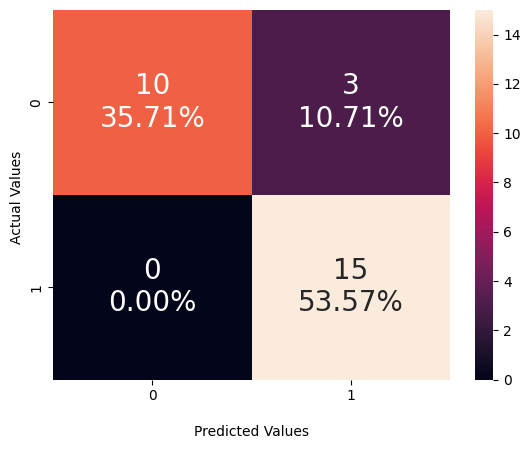

In [ ]:
predictions = [list(clin_pred), list(mut_pred), list(exp_pred)]
#names = ['CLIN', 'MUT', 'EXP']
predictions = [list(i) for i in zip(*predictions)]

res = ensembleModelHoldout(predictions, [], clin_y_final_test, "CLIN+MUT+EXP", useavg=False, verbose=True)